In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf



In [6]:
#Download data

end_date = datetime.today()
# start_date = end_date + timedelta(days=-5*365)
start_date = datetime(2000, 1, 1)


spx = yf.download("^GSPC", start=start_date, end=end_date)

hist_close = spx['Close']
hist_ret = hist_close / hist_close.shift(1) - 1.0     # shift 1 shifts forward one day; today has yesterday's price
# hist_ret = hist_close.pct_change(1)
hist_ret.dropna(inplace=True)
hist_ret = hist_ret * 100.0
print(hist_ret.describe())
print(f'Skew: {scipy.stats.skew(hist_ret)}, Kurtosis: {scipy.stats.kurtosis(hist_ret)}')

[*********************100%***********************]  1 of 1 completed

Ticker        ^GSPC
count   6558.000000
mean       0.031256
std        1.218540
min      -11.984055
25%       -0.472205
50%        0.063912
75%        0.588749
max       11.580037
Skew: [-0.12116621], Kurtosis: [10.50539211]


In [7]:
#ARIMA Model

#Step One: Identify (p, d, q)

# price is known to be non-stationary; return is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(hist_close)
print(f'ADF Statistic: {result[0]}, p-value: {result[1]}')  # null hypothesis: unit root exists; can't reject null.

result = adfuller(hist_ret)
print(f'ADF Statistic: {result[0]}, p-value: {result[1]}')   # reject null hypothesis of unit root ==> stationary          


ADF Statistic: 2.946052600580181, p-value: 1.0
ADF Statistic: -15.305568964135473, p-value: 4.254687538987741e-28


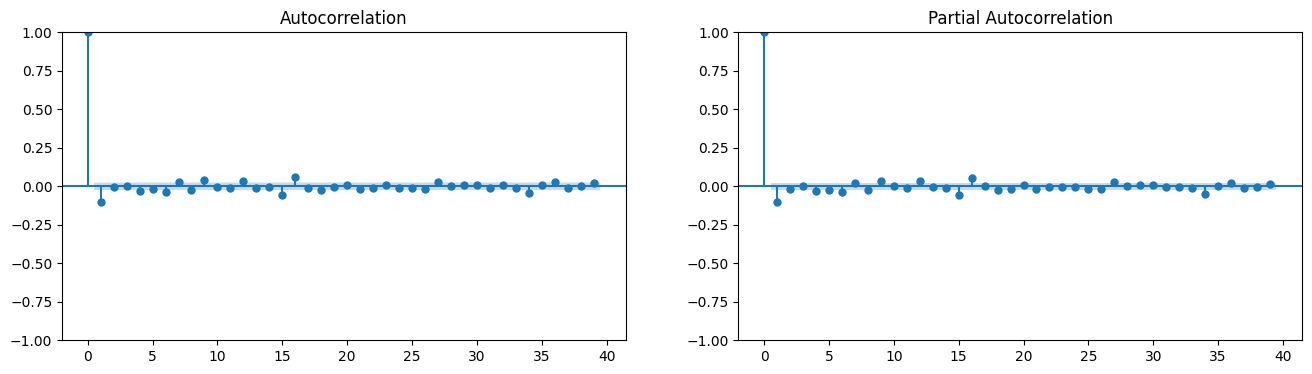

        acf      pacf
1 -0.101471 -0.101487
2 -0.006614 -0.017091
3  0.001981 -0.000440
4 -0.029933 -0.030225
5 -0.014721 -0.021123


In [8]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16, 4))
plot_acf(hist_ret, ax=axes[0])          # determines MA(q)
plot_pacf(hist_ret, ax=axes[1])         # determines AR(p)
plt.show()

act_stats = acf(hist_ret, fft=False)[1:40]                
acf_df = pd.DataFrame([act_stats]).T
acf_df.columns = ['acf']
acf_df.index += 1

pacf_stats = pacf(hist_ret)[1:40]                        
pacf_df = pd.DataFrame([pacf_stats]).T
pacf_df.columns = ['pacf']
pacf_df.index += 1

df_acf_pcaf = pd.concat([acf_df, pacf_df], axis=1)
print(df_acf_pcaf.head())

In [9]:
# acf/pacf suggests higher order of arounds 35 business days, which makes the model practically unusable.
# instead, let's constraint the order to 5 business days and use AIC to pick up the best fit

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima.model import ARIMA

# Clean the series
hist_training = hist_ret.iloc[:-45].dropna()
hist_testing  = hist_ret.iloc[-45:].dropna()

dict_aic = {}

for p in range(6):
    for q in range(6):
        try:
            model = ARIMA(hist_training, order=(p, 0, q))
            model_fit = model.fit()
            dict_aic[(p, q)] = model_fit.aic
        except Exception as e:
            print(f"ARIMA({p},0,{q}) failed: {e}")

df_aic = pd.DataFrame.from_dict(dict_aic, orient='index', columns=['aic'])

if df_aic.empty:
    raise ValueError("No ARIMA models could be fitted. Check your data.")

# Extract best (p,q)
p, q = df_aic.aic.idxmin()

print(f"Best ARIMA order is ({p}, 0, {q})")


Best ARIMA order is (5, 0, 5)


In [10]:
#Step Two: Fit the Model
	
# train the selected model


model = ARIMA(hist_training, order=(p, 0, q))
arima_fitted = model.fit()   # no disp argument
arima_fitted.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  ^GSPC   No. Observations:                 6513
Model:                 ARIMA(5, 0, 5)   Log Likelihood              -10489.467
Date:                Sun, 01 Feb 2026   AIC                          21002.935
Time:                        18:53:43   BIC                          21084.313
Sample:                             0   HQIC                         21031.078
                               - 6513                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0310      0.014      2.242      0.025       0.004       0.058
ar.L1         -0.7242      0.065    -11.160      0.000      -0.851      -0.597
ar.L2         -0.1142      0.084     -1.367      0.172      -0.278       0.049
ar.L3         -0.4512      0.080     -5.660      0.000      -0.607      -0.295
ar.L4         -0.0020      0.081     -0.025      0.980      -0.161       0.157
ar.L5          0.4952      0.043     11.574      0.000       0.411       0.579
ma.L1          0.6209      0.063      9.901      0.000       0.498       0.744
ma.L2          0.0251      0.076      0.330      0.741      -0.124       0.174
ma.L3          0.4337      0.072      6.036      0.000       0.293       0.575
ma.L4         -0.0817      0.073     -1.119      0.263      -0.225       0.061
ma.L5         -0.5421      0.038    -14.221      0.000      -0.617      -0.467
sigma2         1.4668      0.012    124.699      0.000       1.444       1.490
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             23569.61
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.38
Prob(H) (two-sided):                  0.17   Kurtosis:                        12.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

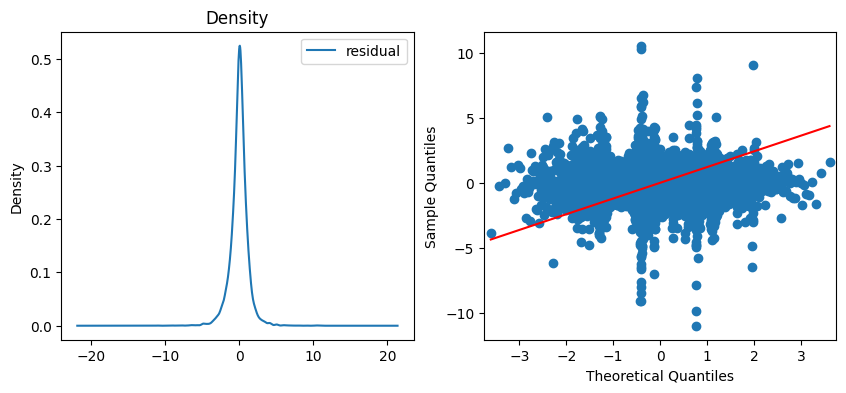

Statistics=1243.593, p=0.000
Statistics=0.905, p=0.000


In [11]:
#Step Three: Residual Analysis


residuals = pd.DataFrame(arima_fitted.resid, columns=['residual'])
fig, ax = plt.subplots(1,2, figsize=(10, 4))
# residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[0])
sm.qqplot(residuals, line='s', ax=ax[1])
plt.show()

# normality test
from scipy.stats import shapiro, normaltest
stat, p = normaltest(residuals)
print(f'Statistics={stat[0]:.3f}, p={p[0]:.3f}')       # H0: Gaussian
stat, p = shapiro(residuals)
print(f'Statistics={stat:.3f}, p={p:.3f}')       # H0: Gaussian

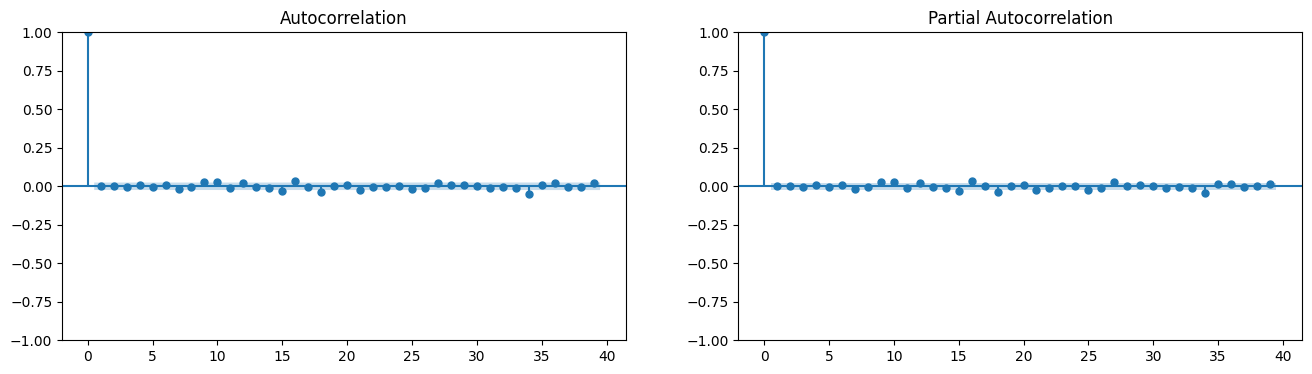

In [12]:
# Because we limit the lag orders; there still has remaining autocorrelation.
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(residuals, ax=axes[0])
plot_pacf(residuals, ax=axes[1])
plt.show()

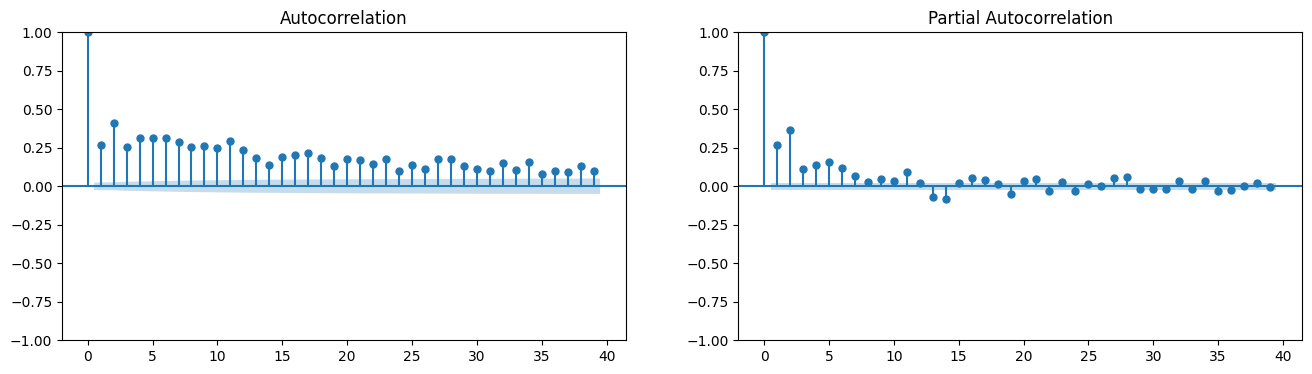

In [13]:
# In addition, There exists autocorrelation in squared residuals, suggesting GARCH
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(residuals**2, ax=axes[0])
plot_pacf(residuals**2, ax=axes[1])
plt.show()

In [14]:
#Step Four: Forecast



return_predicted = arima_fitted.predict()

# Convert predicted returns into a price path
price_predicted = hist_close.iloc[0] * np.cumprod(1 + return_predicted)


In [15]:
n_steps = hist_testing.shape[0]

# Get forecast object
forecast_obj = arima_fitted.get_forecast(steps=n_steps)

# Extract components
forecasted = forecast_obj.predicted_mean
forecasted_std = forecast_obj.se_mean
forecasted_bounds = forecast_obj.conf_int()


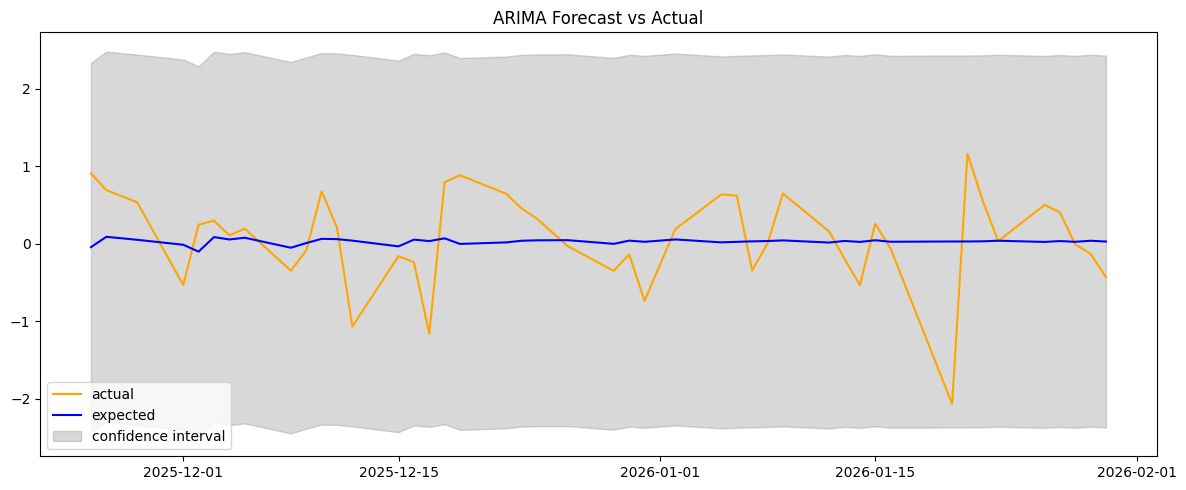

In [16]:

# Forecast
n_steps = hist_testing.shape[0]
forecast_obj = arima_fitted.get_forecast(steps=n_steps)

# Extract components
forecasted = forecast_obj.predicted_mean
forecasted_std = forecast_obj.se_mean
forecasted_bounds = forecast_obj.conf_int()

# Align forecast with test index
forecasted.index = hist_testing.index
forecasted_bounds.index = hist_testing.index

# Plot
plt.figure(figsize=(12, 5))
plt.plot(hist_testing, label='actual', color='orange')
plt.plot(forecasted, label='expected', color='blue')

# Confidence interval
plt.fill_between(
    hist_testing.index,
    forecasted_bounds.iloc[:, 0],
    forecasted_bounds.iloc[:, 1],
    color='gray',
    alpha=0.3,
    label='confidence interval'
)

plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
#GARCH

#Step One: Identify Lag Orders

from arch import arch_model
dict_aic = {}

for l in range(5):
    for p in range(1, 5):
        for q in range(1, 5):
            try:
                split_date = hist_ret.index[-45]
                model = arch_model(hist_ret, mean='ARX', lags=l, vol='Garch', p=p, o=0, q=q, dist='Normal')
                res = model.fit(last_obs=split_date)
                dict_aic[(l, p, q)] = res.aic
            except:
                pass

df_aic = pd.DataFrame.from_dict(dict_aic, orient='index', columns=['aic'])
l, p, q = df_aic[df_aic.aic == df_aic.aic.min()].index[0]
print(f'ARIMA-GARCH order is ({l}, {p}, {q})')

Iteration:      1,   Func. Count:      6,   Neg. LLF: 546857299076916.5
Iteration:      2,   Func. Count:     15,   Neg. LLF: 3614377302.060046
Iteration:      3,   Func. Count:     22,   Neg. LLF: 12446.618263863464
Iteration:      4,   Func. Count:     29,   Neg. LLF: 9285.116580304477
Iteration:      5,   Func. Count:     35,   Neg. LLF: 9050.725420147948
Iteration:      6,   Func. Count:     41,   Neg. LLF: 8983.254725950803
Iteration:      7,   Func. Count:     47,   Neg. LLF: 9110.0151880074
Iteration:      8,   Func. Count:     53,   Neg. LLF: 8965.385528303575
Iteration:      9,   Func. Count:     58,   Neg. LLF: 8965.367215894345
Iteration:     10,   Func. Count:     63,   Neg. LLF: 8965.35636953955
Iteration:     11,   Func. Count:     68,   Neg. LLF: 8965.35612829296
Iteration:     12,   Func. Count:     73,   Neg. LLF: 8965.35612410922
Iteration:     13,   Func. Count:     77,   Neg. LLF: 8965.356124108624
Optimization terminated successfully    (Exit mode 0)
            Cu

In [20]:
#Step Two: Fit the Model
model = arch_model(hist_ret, mean='ARX', lags=l, vol='Garch', p=p, o=0, q=q, dist='Normal')
res = model.fit(last_obs=split_date)

Iteration:      1,   Func. Count:     12,   Neg. LLF: 279354.41831643635
Iteration:      2,   Func. Count:     29,   Neg. LLF: 56778.080799923104
Iteration:      3,   Func. Count:     44,   Neg. LLF: 42062.22714285119
Iteration:      4,   Func. Count:     59,   Neg. LLF: 27061.495692239427
Iteration:      5,   Func. Count:     72,   Neg. LLF: 130021.31975693203
Iteration:      6,   Func. Count:     86,   Neg. LLF: 29169.218978667683
Iteration:      7,   Func. Count:    100,   Neg. LLF: 12605.825213810122
Iteration:      8,   Func. Count:    114,   Neg. LLF: 11999.001221742277
Iteration:      9,   Func. Count:    128,   Neg. LLF: 9470.978928588202
Iteration:     10,   Func. Count:    140,   Neg. LLF: 9136.880322201983
Iteration:     11,   Func. Count:    153,   Neg. LLF: 8939.20173464687
Iteration:     12,   Func. Count:    165,   Neg. LLF: 8939.823954702544
Iteration:     13,   Func. Count:    177,   Neg. LLF: 8942.213356290064
Iteration:     14,   Func. Count:    189,   Neg. LLF: 8938

In [21]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                  ^GSPC   R-squared:                       0.007
Mean Model:                        AR   Adj. R-squared:                  0.007
Vol Model:                      GARCH   Log-Likelihood:               -8936.79
Distribution:                  Normal   AIC:                           17893.6
Method:            Maximum Likelihood   BIC:                           17961.4
                                        No. Observations:                 6509
Date:                Sun, Feb 01 2026   Df Residuals:                     6504
Time:                        18:54:56   Df Model:                            5
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0752  1.084e-02      6.945  3.793e-12   [5.401e-02,9.648e-02]
^GSPC[1]      -0.0557  1.318e-02     -4.230  2.333e-05 [-8.157e-02,-2.992e-02]
^GSPC[2]      -0.0255  1.377e-02     -1.852  6.401e-02  [-5.249e-02,1.486e-03]
^GSPC[3]      -0.0245  1.341e-02     -1.825  6.801e-02  [-5.075e-02,1.811e-03]
^GSPC[4]      -0.0116  1.402e-02     -0.830      0.407  [-3.911e-02,1.584e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0452  9.293e-03      4.862  1.163e-06 [2.697e-02,6.340e-02]
alpha[1]       0.0926  2.080e-02      4.455  8.404e-06   [5.188e-02,  0.133]
alpha[2]       0.1280  2.077e-02      6.163  7.149e-10   [8.728e-02,  0.169]
beta[1]        0.1411      0.246      0.574      0.566     [ -0.341,  0.623]
beta[2]        0.6049      0.220      2.750  5.961e-03     [  0.174,  1.036]
============================================================================

Covariance estimator: robust
"""

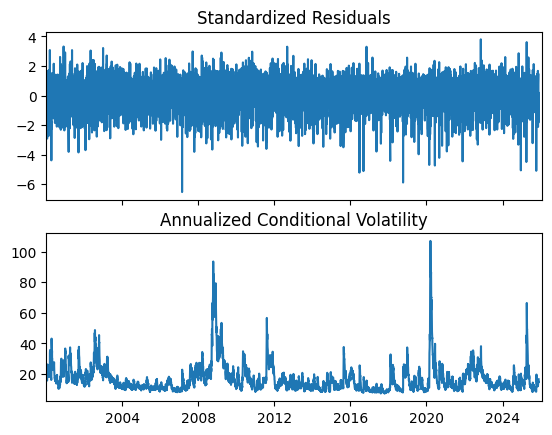

In [22]:
#Step Three: Evaluate Model via Residuals
res.plot(annualize='D')
std_resid = res.resid / res.conditional_volatility
std_resid.dropna(inplace=True)

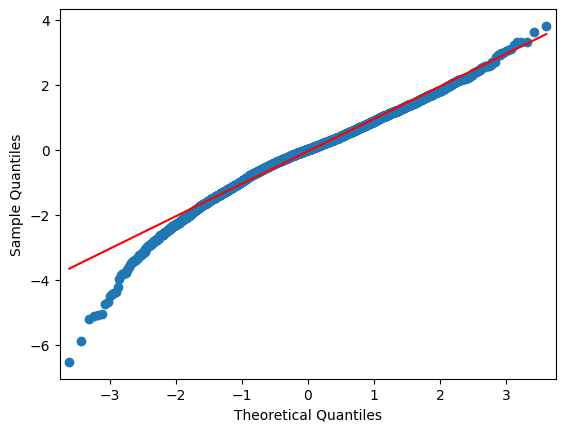

In [23]:
sm.qqplot(std_resid, line='s');

In [24]:
stat, p = normaltest(std_resid)
print(f'Statistics={stat:.3f}, p={p:.3f}')       # H0: Gaussian
stat, p = shapiro(std_resid)
print(f'Statistics={stat:.3f}, p={p:.3f}')       # H0: Gaussian

Statistics=513.501, p=0.000
Statistics=0.981, p=0.000


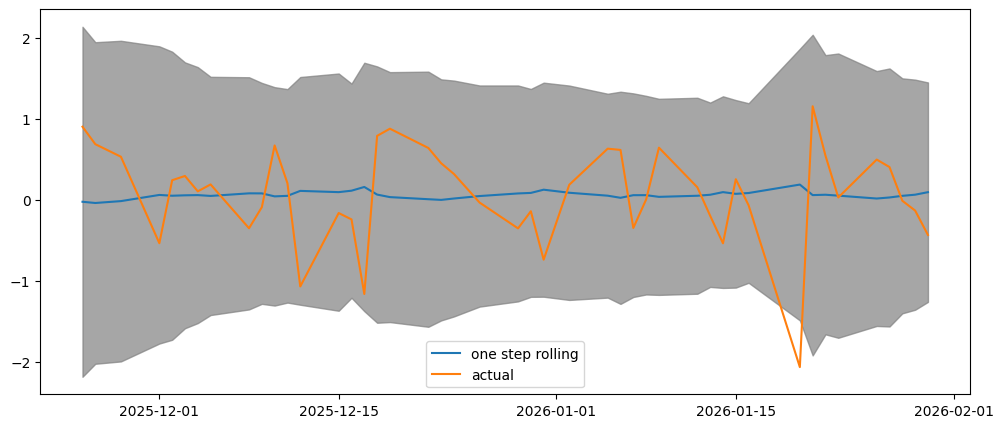

In [25]:
#Step Four: Forecast

forecasts = res.forecast(horizon=1, start=split_date)

conf = np.sqrt(forecasts.variance[split_date:])*1.96

plt.figure(figsize=(12, 5))
plt.plot(forecasts.mean[split_date:], label='one step rolling')
plt.plot(hist_ret[split_date:], label='actual')
plt.fill_between(hist_ret[split_date:].index, (forecasts.mean[split_date:]-conf).values.reshape(-1), (forecasts.mean[split_date:]+conf).values.reshape(-1), color='gray', alpha=0.7)
plt.legend()
plt.show()